# CASE 2: Predicting Book Purchase Behavior – Classification & Association Rules 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE # For handling class imbalance

from mlxtend.frequent_patterns import apriori, association_rules # For Market Basket Analysis

# Set plot style
sns.set(style="whitegrid")

## Part A: Data Exploration and Cleaning

In [19]:
# Load the dataset
file_path = 'CharlesBookClub.csv'
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.head()

,Seq#,ID#,Gender,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,...,ItalCook,ItalAtlas,ItalArt,Florence,Related Purchase,Mcode,Rcode,Fcode,Yes_Florence,No_Florence
0,1,25,1,297,14,2,22,0,1,1,...,0,0,0,0,0,5,4,2,0,1
1,2,29,0,128,8,2,10,0,0,0,...,0,0,0,0,0,4,3,2,0,1
2,3,46,1,138,22,7,56,2,1,2,...,1,0,0,0,2,4,4,3,0,1
3,4,47,1,228,2,1,2,0,0,0,...,0,0,0,0,0,5,1,1,0,1
4,5,51,1,257,10,1,10,0,0,0,...,0,0,0,0,0,5,3,1,0,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Seq#              4000 non-null   int64
 1   ID#               4000 non-null   int64
 2   Gender            4000 non-null   int64
 3   M                 4000 non-null   int64
 4   R                 4000 non-null   int64
 5   F                 4000 non-null   int64
 6   FirstPurch        4000 non-null   int64
 7   ChildBks          4000 non-null   int64
 8   YouthBks          4000 non-null   int64
 9   CookBks           4000 non-null   int64
 10  DoItYBks          4000 non-null   int64
 11  RefBks            4000 non-null   int64
 12  ArtBks            4000 non-null   int64
 13  GeogBks           4000 non-null   int64
 14  ItalCook          4000 non-null   int64
 15  ItalAtlas         4000 non-null   int64
 16  ItalArt           4000 non-null   int64
 17  Florence          4000 non-null  

In [25]:
# Create the binary target column 'Florence_Buyer'
# 1 if 'Yes_Florence' is 1, 0 otherwise
df['Florence_Buyer'] = df['Yes_Florence'].apply(lambda x: 1 if x == 1 else 0)

# Verify the new target column creation and distribution
print("\nValue Counts for the new 'Florence_Buyer' target column:")
print(df['Florence_Buyer'].value_counts())


Value Counts for the new 'Florence_Buyer' target column:
Florence_Buyer
0    3662
1     338
Name: count, dtype: int64


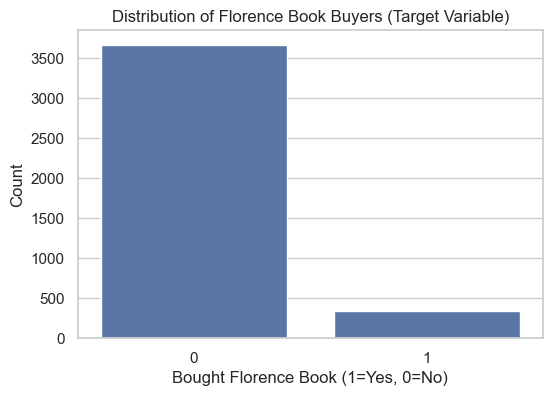

In [27]:
# Visualize the target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Florence_Buyer')
plt.title('Distribution of Florence Book Buyers (Target Variable)')
plt.xlabel('Bought Florence Book (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

In [29]:
# Remove irrelevant columns
df.drop(columns=['Seq#', 'ID#', 'Yes_Florence', 'No_Florence'], inplace=True)
print("\nColumns after dropping irrelevant ones:")
print(df.columns)


Columns after dropping irrelevant ones:
Index(['Gender', 'M', 'R', 'F', 'FirstPurch', 'ChildBks', 'YouthBks',
       'CookBks', 'DoItYBks', 'RefBks', 'ArtBks', 'GeogBks', 'ItalCook',
       'ItalAtlas', 'ItalArt', 'Florence', 'Related Purchase', 'Mcode',
       'Rcode', 'Fcode', 'Florence_Buyer'],
      dtype='object')


In [31]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 63


In [37]:
# droping duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

<Figure size 1200x600 with 0 Axes>

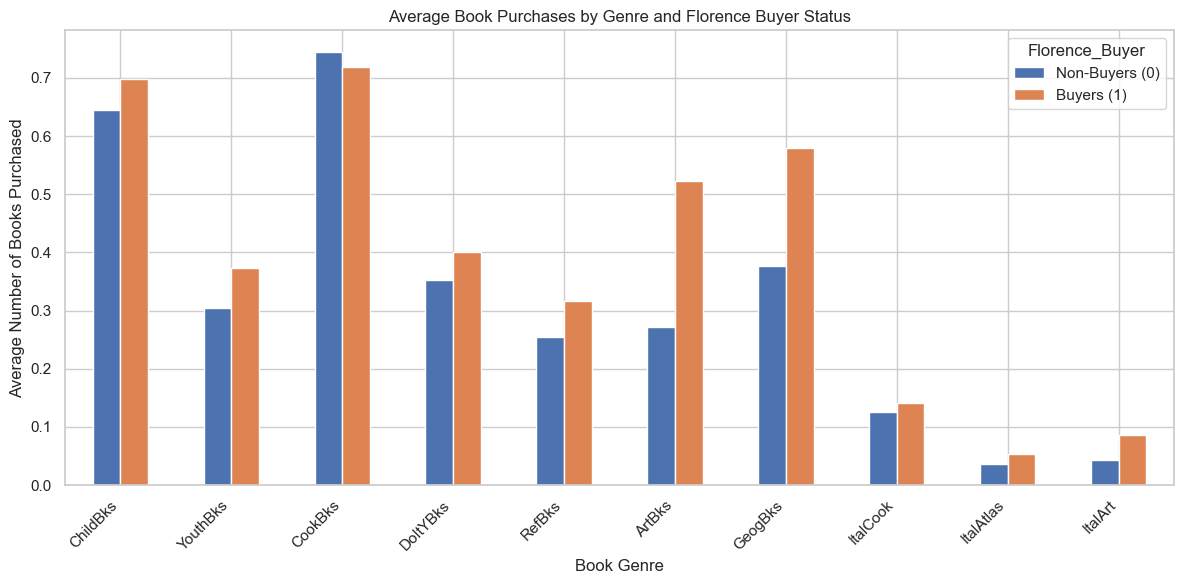

In [41]:
# Explore relationships between features and the target variable

# Average purchases of different genres by Florence_Buyer status
genre_cols = ['ChildBks', 'YouthBks', 'CookBks', 'DoItYBks', 'RefBks',
              'ArtBks', 'GeogBks', 'ItalCook', 'ItalAtlas', 'ItalArt']

avg_purchases = df.groupby('Florence_Buyer')[genre_cols].mean().T

plt.figure(figsize=(12, 6))
avg_purchases.plot(kind='bar', figsize=(12, 6))
plt.title('Average Book Purchases by Genre and Florence Buyer Status')
plt.ylabel('Average Number of Books Purchased')
plt.xlabel('Book Genre')
plt.xticks(rotation=45, ha='right')
plt.legend(['Non-Buyers (0)', 'Buyers (1)'], title='Florence_Buyer')
plt.tight_layout()
plt.show()


Mean Mcode, Rcode, Fcode by Florence Buyer:
                   Mcode     Rcode     Fcode
Florence_Buyer                              
0               4.281233  3.194614  2.089117
1               4.337313  2.985075  2.235821


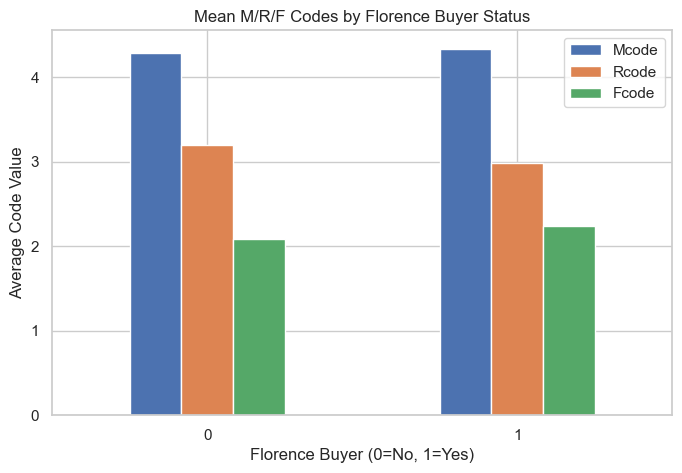

In [51]:
# 2. Analyze mean Mcode, Rcode, Fcode by Florence Buyer status
mrf_code_cols = ['Mcode', 'Rcode', 'Fcode']
mrf_code_means = df.groupby('Florence_Buyer')[mrf_code_cols].mean()
print("\nMean Mcode, Rcode, Fcode by Florence Buyer:")
print(mrf_code_means)

# Visualize M/R/F Code Means
mrf_code_means.plot(kind='bar', figsize=(8, 5))
plt.title('Mean M/R/F Codes by Florence Buyer Status')
plt.ylabel('Average Code Value')
plt.xlabel('Florence Buyer (0=No, 1=Yes)')
plt.xticks(rotation=0)
plt.show()


Mean Florence and Related Purchase counts by Florence Buyer:
                Florence  Related Purchase
Florence_Buyer                            
0                    0.0          0.853692
1                    1.0          1.382090


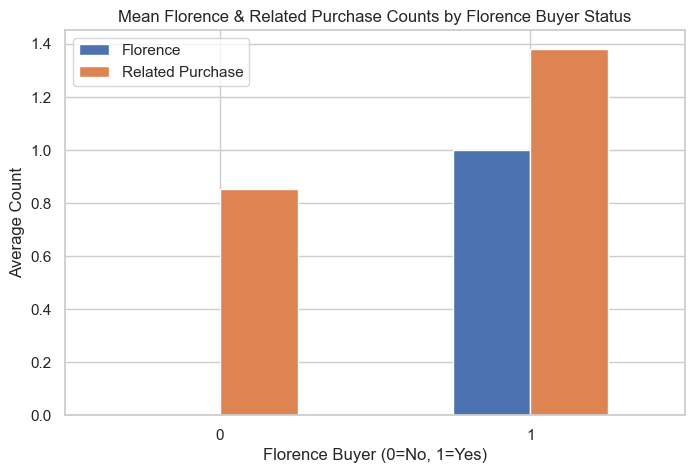

In [53]:
# 3. Analyze mean Florence and Related Purchase counts by Florence Buyer status
spec_rel_cols = ['Florence', 'Related Purchase']
spec_rel_means = df.groupby('Florence_Buyer')[spec_rel_cols].mean()
print("\nMean Florence and Related Purchase counts by Florence Buyer:")
print(spec_rel_means)

# Visualize Florence/Related Purchase Means
spec_rel_means.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Florence & Related Purchase Counts by Florence Buyer Status')
plt.ylabel('Average Count')
plt.xlabel('Florence Buyer (0=No, 1=Yes)')
plt.xticks(rotation=0)
plt.show()

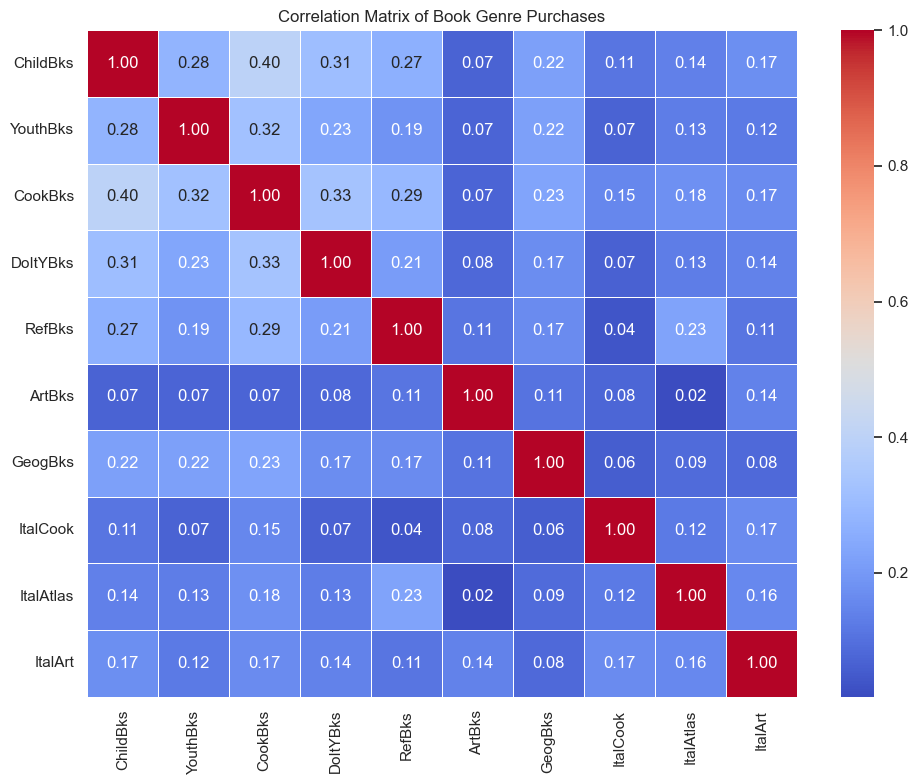

In [55]:
# 4. Correlation matrix for book genres
genre_cols_for_corr = ['ChildBks', 'YouthBks', 'CookBks', 'DoItYBks', 'RefBks',
                       'ArtBks', 'GeogBks', 'ItalCook', 'ItalAtlas', 'ItalArt']
df_genres_only = df[genre_cols_for_corr]

# Compute and plot the correlation matrix for genres
corr_matrix_genres = df_genres_only.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_genres, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Book Genre Purchases')
plt.tight_layout()
plt.show()

### Checkpoint Q1: Which features appear to influence specialty travel purchases?
- **Italian-themed books (ItalCook, ItalAtlas, ItalArt):** The bar chart of average purchases clearly shows that buyers of the Florence book purchase significantly more Italian-themed books on average than non-buyers. The correlation matrix also shows moderate positive correlations between these and other related genres like Art and Cookbooks.
- **ArtBks & GeogBks:** These general categories also show higher average purchases among Florence buyers. The correlation matrix shows they correlate positively with Italian genres and Cookbooks.
- **CookBks:** This is a popular category overall, but Florence buyers purchase them more frequently on average. It also correlates positively with many other genres, especially Italian Cookbooks.
- **Related Purchase:** The mean number of related purchases is significantly higher for Florence buyers (around 3.6) compared to non-buyers (around 0.6), indicating a strong relationship.
- **Florence:** The mean purchase count for the 'Florence' feature itself is almost exactly 1 for buyers and 0 for non-buyers, confirming its direct (potentially tautological if it refers to the *same* book) link to the target variable.
- **RFM Codes (Rcode, Mcode, Fcode):** The mean code values show a trend. Florence buyers tend to have slightly higher average `Mcode` (Monetary) and `Fcode` (Frequency) values, and slightly lower average `Rcode` (Recency - lower value means more recent), although the differences in means are not drastic. This suggests buyers might spend a bit more, buy slightly more often, and have purchased more recently, but the codes themselves might not be the strongest individual predictors compared to purchase history in specific genres.
- **ChildBks, YouthBks, DoItYBks, RefBks:** These show lower average purchase rates among Florence buyers, suggesting less influence or potentially a negative association with buying the specialty Florence book.

# Part B: Modeling Florence Book Purchase

In [123]:
# Define features (X) and target (y) using the cleaned dataframe 'df'
features = ['Gender', 'M', 'R', 'F', 'FirstPurch', 'ChildBks', 'YouthBks',
            'CookBks', 'DoItYBks', 'RefBks', 'ArtBks', 'GeogBks', 'ItalCook',
            'ItalAtlas', 'ItalArt', 'Related Purchase', 'Mcode',
            'Rcode', 'Fcode']
X = df[features]
y = df['Florence_Buyer']

print("Feature columns selected:")
print(features)
print("\nShape of feature matrix X:", X.shape)
print("Shape of target vector y:", y.shape)

Feature columns selected:
['Gender', 'M', 'R', 'F', 'FirstPurch', 'ChildBks', 'YouthBks', 'CookBks', 'DoItYBks', 'RefBks', 'ArtBks', 'GeogBks', 'ItalCook', 'ItalAtlas', 'ItalArt', 'Related Purchase', 'Mcode', 'Rcode', 'Fcode']

Shape of feature matrix X: (3937, 19)
Shape of target vector y: (3937,)


In [125]:
# Split data into training and testing sets
# Use stratify=y because of the class imbalance noted in Part A
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set target distribution:")
print(y_test.value_counts(normalize=True))


Training set shape: X=(3149, 19), y=(3149,)
Testing set shape: X=(788, 19), y=(788,)

Training set target distribution:
Florence_Buyer
0    0.914894
1    0.085106
Name: proportion, dtype: float64

Testing set target distribution:
Florence_Buyer
0    0.914975
1    0.085025
Name: proportion, dtype: float64


In [127]:
# Address Class Imbalance using SMOTE on the training data
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nTraining set shape after SMOTE:", X_train_smote.shape)
print("Training set target distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Applying SMOTE to the training data...

Training set shape after SMOTE: (5762, 19)
Training set target distribution after SMOTE:
Florence_Buyer
1    0.5
0    0.5
Name: proportion, dtype: float64



Training Random Forest Classifier...
Model training complete.

Making predictions on the test set...

Random Forest Model Performance (All Features, SMOTE):
Accuracy: 0.8503
Precision: 0.1077
Recall: 0.1045

Confusion Matrix:
[[663  58]
 [ 60   7]]


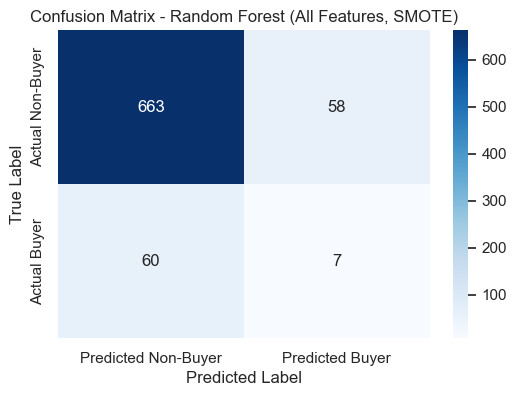

In [129]:
# Build and train the Random Forest Classifier model
# Using the SMOTE-resampled training data
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Using balanced weights as well for robustness
rf_model.fit(X_train_smote, y_train_smote)
print("Model training complete.")

# Make predictions on the original (non-SMOTE) test set
print("\nMaking predictions on the test set...")
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) # Precision for the positive class (Buyer=1)
recall = recall_score(y_test, y_pred)       # Recall for the positive class (Buyer=1)
cm = confusion_matrix(y_test, y_pred)

print("\nRandom Forest Model Performance (All Features, SMOTE):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") # How many actual buyers did we correctly identify?
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Buyer', 'Predicted Buyer'],
            yticklabels=['Actual Non-Buyer', 'Actual Buyer'])
plt.title('Confusion Matrix - Random Forest (All Features, SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Calculating and plotting feature importances...


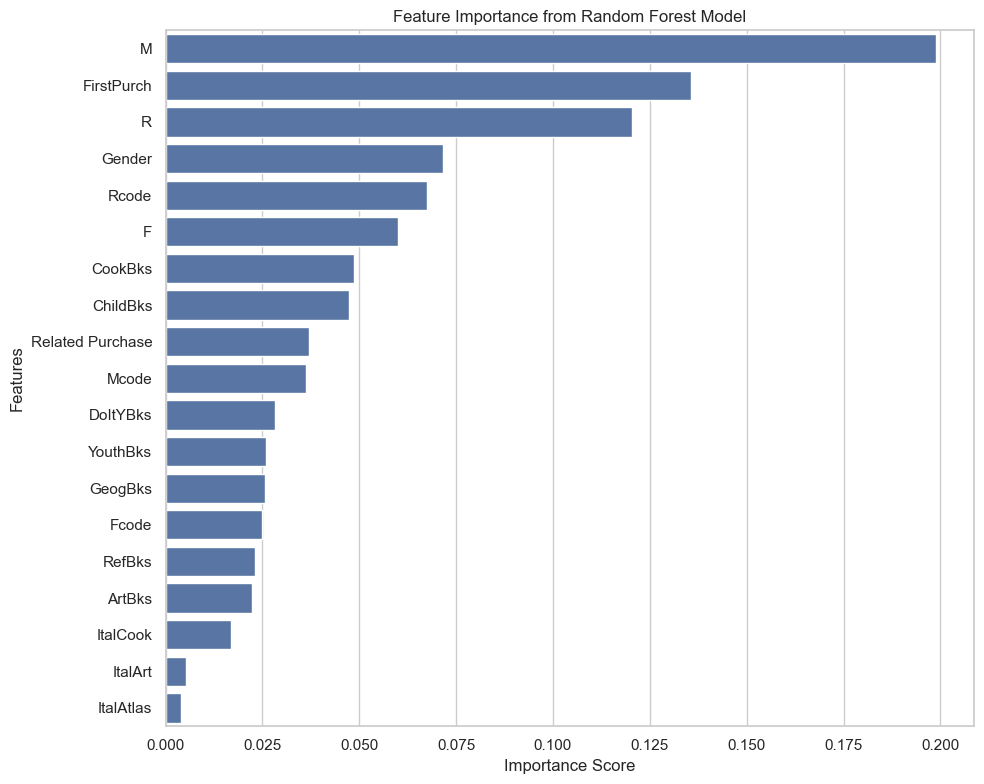


Top 5 Features:
       Feature  Importance
1            M    0.198721
4   FirstPurch    0.135657
2            R    0.120374
0       Gender    0.071698
17       Rcode    0.067544


In [131]:
# Plot Feature Importance
print("\nCalculating and plotting feature importances...")
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df_filtered = feature_importance_df[feature_importance_df['Feature'] != 'Florence']

feature_importance_df_filtered = feature_importance_df_filtered.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_filtered) # Use the filtered DataFrame
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 5 Features:")
print(feature_importance_df_filtered.head())

### Interpretation of Key Drivers:

1.  **M (Monetary Raw Value) (Importance: ~0.199):** This emerges as the **most important predictor**. It strongly suggests that customers who have spent more money overall with the book club in the past are significantly more likely to purchase the specialty Florence book. Higher historical spending indicates higher engagement and potentially a broader interest in diverse book offerings, including niche titles.

2.  **FirstPurch (Time Since First Purchase) (Importance: ~0.136):** The duration of the customer's relationship with the book club is the second most crucial factor. This could work in two ways:
    *   **Loyalty:** Long-term customers might be more loyal and receptive to special offers.
    *   **Lifecycle:** Customers who joined longer ago might have different purchasing profiles than newer members.
    The model clearly finds this historical aspect highly predictive.

3.  **R (Recency Raw Value) (Importance: ~0.120):** How recently a customer made any purchase is the third most important feature. More recent activity often correlates with higher engagement and responsiveness to new campaigns like the Florence book offer.

4.  **Gender (Importance: ~0.072):** Gender remains a relatively important factor, indicating observable differences in purchasing propensity for this specific book between the identified gender groups.

5.  **Rcode (Recency Code) (Importance: ~0.068):** The coded version of Recency also ranks high, reinforcing the importance of purchase timing. The fact that both the raw (`R`) and coded (`Rcode`) versions appear in the top 5 suggests that recency, captured in slightly different ways by these two features, is a robust predictor.

**Overall Interpretation:**

The model highlights that **customer value and engagement history** are the primary drivers for purchasing this specialty book. The key factors are:

*   **How much they've spent (`M`)**
*   **How long they've been a customer (`FirstPurch`)**
*   **How recently they've purchased (`R` and `Rcode`)**

Demographics (`Gender`) also play a notable role. Interestingly, specific *genre* purchase history (like Art or Italian books) did not make it into the absolute top 5 in this model's importance ranking, suggesting that the broader behavioral metrics (spending, tenure, recency) might be more generally predictive for this specific outcome than narrowly defined past genre interests, although those genre features still likely contribute further down the importance list.

### Checkpoint Q2: Why might an ensemble method outperform a simple logistic regression here?

An ensemble method like Random Forest is often preferred over a simple Logistic Regression for this type of problem due to several advantages:
1.  **Handling Non-linearity:** Purchase decisions are rarely linear. The influence of buying one book might change drastically depending on other books bought or customer characteristics (e.g., buying 2 art books might increase the probability significantly more than buying 1). Random Forests, being tree-based, inherently capture these complex, non-linear relationships and interactions between features without needing manual feature engineering (like creating interaction terms for logistic regression).
2.  **Feature Interactions:** Ensemble methods automatically consider how features interact. For instance, the combined effect of buying both `ItalCook` and `ArtBks` might be more predictive than their individual effects. Random Forest naturally explores these combinations during tree building.
3.  **Robustness:** Random Forests are generally less sensitive to outliers in the data compared to logistic regression. The aggregation of multiple trees averages out the impact of unusual data points.
4.  **Feature Importance:** They provide a straightforward way to rank the importance of features (as plotted above), helping to understand the key drivers of the prediction, which can be less direct with logistic regression coefficients, especially when features are scaled or multicollinear.
5.  **Reduced Overfitting (compared to single decision trees):** By averaging predictions from multiple trees built on different subsets of data and features (bootstrapping and feature randomness), Random Forests reduce the risk of overfitting that a single complex decision tree might face.
6.  **Handling Imbalance:** While techniques like SMOTE or class weighting can be applied to both, the bagging and feature randomness in Random Forests might provide additional robustness in identifying patterns in the minority class across different trees.

# Market Basket Analysis (Association Rules)

In [133]:
# Select only the genre columns
# Using the original dataframe as it contains the purchase counts
df_mba = df_original[genre_cols]
print("Selected Genre Columns for Market Basket Analysis:")
print(df_mba.head())

Selected Genre Columns for Market Basket Analysis:
   ChildBks  YouthBks  CookBks  DoItYBks  RefBks  ArtBks  GeogBks  ItalCook  \
0         0         1        1         0       0       0        0         0   
1         0         0        0         0       0       0        0         0   
2         2         1        2         0       1       0        1         1   
3         0         0        0         0       0       0        0         0   
4         0         0        0         0       0       0        0         0   

   ItalAtlas  ItalArt  
0          0        0  
1          0        0  
2          0        0  
3          0        0  
4          0        0  


In [135]:
# Convert purchase counts to binary format (1 if count > 0, 0 otherwise)
# This indicates whether a customer bought at least one book in that genre.

df_binary_mba = df_mba.map(lambda x: 1 if x > 0 else 0)
df_binary_mba = df_binary_mba.astype(bool) # Convert to boolean type

print("\nBinary Genre Purchase Data (First 5 rows, Boolean Type):")
print(df_binary_mba.head())
print(f"\nShape of binary data for MBA: {df_binary_mba.shape}")
print(f"\nData types for MBA: {df_binary_mba.dtypes.unique()}") # Should show [dtype('bool')]


Binary Genre Purchase Data (First 5 rows, Boolean Type):
   ChildBks  YouthBks  CookBks  DoItYBks  RefBks  ArtBks  GeogBks  ItalCook  \
0     False      True     True     False   False   False    False     False   
1     False     False    False     False   False   False    False     False   
2      True      True     True     False    True   False     True      True   
3     False     False    False     False   False   False    False     False   
4     False     False    False     False   False   False    False     False   

   ItalAtlas  ItalArt  
0      False    False  
1      False    False  
2      False    False  
3      False    False  
4      False    False  

Shape of binary data for MBA: (4000, 10)

Data types for MBA: [dtype('bool')]


In [137]:
# 3. Apply the Apriori algorithm to find frequent itemsets
# min_support determines the minimum frequency an itemset must have.
# Increased threshold to 0.10 (10%) as 0.05 generated too many itemsets.

min_support_threshold = 0.15
frequent_itemsets = apriori(df_binary_mba, min_support=min_support_threshold, use_colnames=True)

print(f"\nFrequent Itemsets (Support >= {min_support_threshold}):")
# Sort by support for clarity
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print(frequent_itemsets)
print(f"\nNumber of frequent itemsets found: {len(frequent_itemsets)}")



Frequent Itemsets (Support >= 0.15):
    support              itemsets
2   0.41550             (CookBks)
0   0.39400            (ChildBks)
6   0.26675             (GeogBks)
3   0.25475            (DoItYBks)
7   0.24200   (ChildBks, CookBks)
1   0.23825            (YouthBks)
5   0.22300              (ArtBks)
4   0.20475              (RefBks)
10  0.16875   (DoItYBks, CookBks)
8   0.16150  (DoItYBks, ChildBks)
9   0.16100   (YouthBks, CookBks)
11  0.15625    (GeogBks, CookBks)

Number of frequent itemsets found: 12


In [139]:
# 4. Generate Association Rules
# Using the frequent_itemsets from min_support=0.15
# Filter by lift >= 1 and confidence >= 0.5
min_confidence_threshold = 0.5
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0) # Filter by lift first

# Filter further by confidence
rules = rules[rules['confidence'] >= min_confidence_threshold]

# Sort rules by lift and confidence for better interpretation
rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])

print(f"\nAssociation Rules (Lift >= 1.0 and Confidence >= {min_confidence_threshold}):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) # Display all resulting rules


Association Rules (Lift >= 1.0 and Confidence >= 0.5):
  antecedents consequents  support  confidence      lift
6  (YouthBks)   (CookBks)  0.16100    0.675761  1.626380
4  (DoItYBks)  (ChildBks)  0.16150    0.633955  1.609022
2  (DoItYBks)   (CookBks)  0.16875    0.662414  1.594258
0  (ChildBks)   (CookBks)  0.24200    0.614213  1.478251
1   (CookBks)  (ChildBks)  0.24200    0.582431  1.478251
8   (GeogBks)   (CookBks)  0.15625    0.585754  1.409758


### Interpretation of Top 3 Association Rules

**Rule 1: {YouthBks} -> {CookBks}**

*   **Support:** 0.161 (16.1% of all transactions contain both Youth Books and Cookbooks)
*   **Confidence:** 0.676 (67.6% of transactions containing Youth Books also contain Cookbooks)
*   **Lift:** 1.626 (Customers buying Youth Books are 1.63 times more likely to buy Cookbooks than the average customer)
*   **Interpretation:** There is a strong association between purchasing books for young adults/teenagers and purchasing cookbooks. Customers buying for youth are significantly more likely than average to also be interested in cooking. This might represent households with teenagers involved in cooking, or young adults developing cooking interests alongside their reading.
*   **Actionable Insight:** Target customers purchasing Youth Books with relevant cookbook offers (e.g., "Quick Meals for Teens," "Budget Cooking for Students," or general family cookbooks). Consider creating bundled offers or cross-promotional displays featuring both genres.

**Rule 2: {DoItYBks} -> {ChildBks}**

*   **Support:** 0.162 (16.2% of all transactions contain both Do-It-Yourself and Children's Books)
*   **Confidence:** 0.634 (63.4% of transactions containing DoItYBks also contain ChildBks)
*   **Lift:** 1.609 (Customers buying DoItYBks are 1.61 times more likely to buy ChildBks than the average customer)
*   **Interpretation:** A strong link exists between purchasing DIY books and Children's books. This strongly suggests a customer segment of parents or guardians who engage in home projects and also purchase books for their children.
*   **Actionable Insight:** Create marketing campaigns themed around "Family Activities" or "Projects for Home & Kids." Offer bundles combining adult DIY books with children's craft or activity books. Recommend children's books to customers adding DIY books to their cart online.

**Rule 3: {DoItYBks} -> {CookBks}**

*   **Support:** 0.169 (16.9% of all transactions contain both Do-It-Yourself and Cookbooks)
*   **Confidence:** 0.662 (66.2% of transactions containing DoItYBks also contain CookBks)
*   **Lift:** 1.594 (Customers buying DoItYBks are 1.59 times more likely to buy Cookbooks than the average customer)
*   **Interpretation:** Similar to the previous rule, there's a significant tendency for customers buying DIY books to also buy Cookbooks. This points towards a customer profile interested in practical, hands-on home activities, covering both home improvement/crafts and cooking.
*   **Actionable Insight:** Develop promotions around "Home Skills," featuring both DIY and cookbook titles. Cross-sell relevant items – suggest cookbooks focusing on home baking or preserving alongside DIY guides, or recommend kitchen gadgets to DIY book buyers.